# Classifying Chest X rays as Pneumoia or Normal

- Dealing with Image data sets
- Performing Data Processing and Augumentation as when Required
- Creating and training CNN using Tensor Flow 2.0

- Linear and Logistic Regression
- Image Processing
- ANN and CNN

DataSet:- 
Test, Train, Val 

What is Pneumonia?
* It is an infection that inflames air sacs in one or both lungs infection can be life-threatening to anyone.
		Germs that cause pneumonia are contagious.
		Type:- Viral and bacterial pneumonia
		
	Symptoms:-
		Coughing, sweating and chills, shortness of breath, feeling  of tiredness or fatigue, loss of appetite, Nausea or vomiting.
		
	Physical Chekups:- 
		Chest X-ray, Blood Culture, Sputum Culture, Pulse Oximetry, CT Scan, Fluid Sample
		 
	Chest X-ray related to Pneumonia:-
		An X-ray will allow to a doc to see lungs, heart and blood vesselsetc to determine the presence of pneumonia.
		Infiltrates that identify and infection
		Low contrast, overlapping organs, blurred boundary
 
### Note:- Use GPU


In [1]:
!nvidia-smi

Sat Dec  2 10:11:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Import the required library
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
tf.random.set_seed(4)

In [4]:
# Creating the PathLib PATH Objects
train_path = Path("/kaggle/input/chest-xray-pneumonia/chest_xray/train")
validation_path = Path("/kaggle/input/chest-xray-pneumonia/chest_xray/val")
test_path = Path("/kaggle/input/chest-xray-pneumonia/chest_xray/test")

In [5]:
#Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

#Output is a generator object
print(train_image_paths)

<generator object Path.glob at 0x7dcaa3e9b840>


In [6]:
#Convert Generator Object to List of elements
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

#Output are coming in "PosiXPath" Objects
print(val_image_paths[:3])

[PosixPath('/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'), PosixPath('/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg'), PosixPath('/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg')]


In [7]:
#Collect Length for training and Validations Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [8]:
 # Every Image has Label in its path , so lets slice it 
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path) -> int:
    return LABELS[str(path).split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])

[1, 1, 1]


In [9]:
# Now we have all training, validation image paths and their respective labels 

BATCH_SIZE = 32

# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3) #channel = 3-> r,g,b
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

# Function used to Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    paths = [str(path) for path in paths]
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [10]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 826 ms, sys: 706 ms, total: 1.53 s
Wall time: 2.77 s
(32, 224, 224, 3)
(32,)


PNEUMONIA


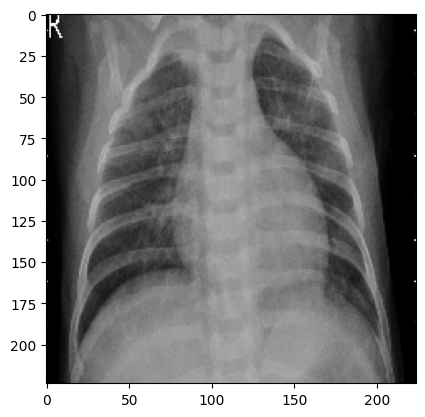

In [11]:
# View a sample Train Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [12]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 17.4 ms, sys: 1.74 ms, total: 19.1 ms
Wall time: 18.3 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


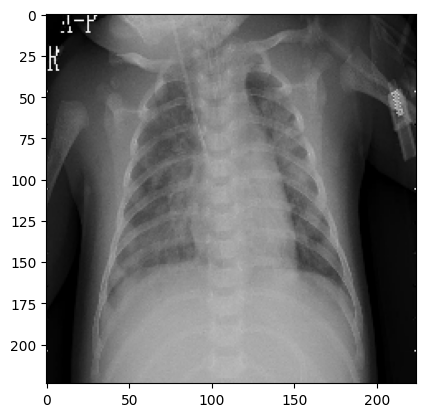

In [13]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [14]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

94668760/94668760 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 23521409 (89.73 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [15]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [16]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [17]:
# Make sure these are correctly calculated
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

# Ensure steps_per_epoch and validation_steps are at least 1
steps_per_epoch = max(1, train_dataset_length // BATCH_SIZE)
validation_steps = max(1, val_dataset_length // BATCH_SIZE)

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=8,
    callbacks=[checkpoint, early_stop],
    validation_data=val_dataset,
    validation_steps=validation_steps,
)


Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9402 - precision: 0.9603 - recall: 0.9658
Epoch 1: val_loss improved from inf to 26.70219, saving model to best_weights.h5
163/163 [==============================] - 125s 456ms/step - loss: 0.1588 - accuracy: 0.9402 - precision: 0.9603 - recall: 0.9658 - val_loss: 26.7022 - val_accuracy: 0.4688 - val_precision: 0.4688 - val_recall: 1.0000
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.9594 - precision: 0.9736 - recall: 0.9716
Epoch 2: val_loss improved from 26.70219 to 3.43712, saving model to best_weights.h5
163/163 [==============================] - 54s 332ms/step - loss: 0.1074 - accuracy: 0.9594 - precision: 0.9736 - recall: 0.9716 - val_loss: 3.4371 - val_accuracy: 0.4688 - val_precision: 0.4688 - val_recall: 1.0000
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0794 - accuracy: 0.9695 - precision: 0.9776 - recall: 0.9819
Epoc

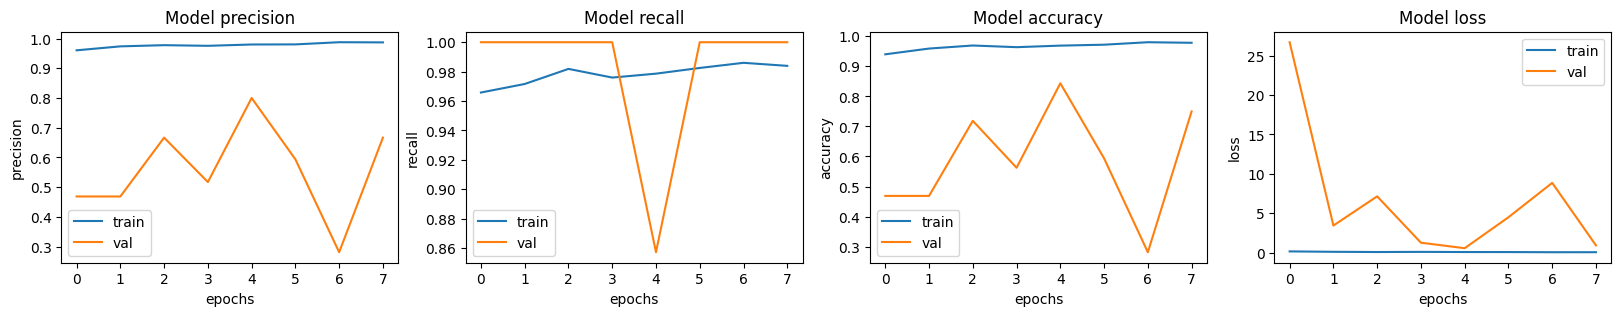

In [18]:
# Interpreting the Metrics 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [19]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weigths + architecture)
model.save("model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

In [21]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [22]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


PNEUMONIA


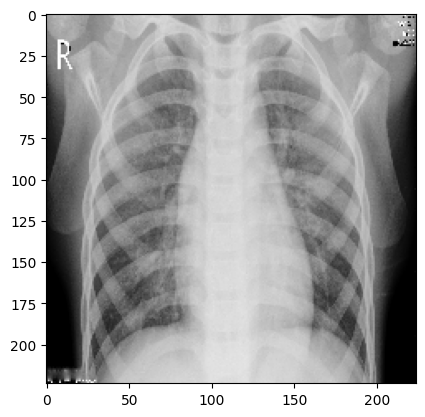

In [23]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [24]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(f" Testing Accuracy : {np.round(acc,2)}%.")
print(f" Testing Precision : {np.round(prec,2)}%." )
print(f" Testing Recall {np.round(rec,2)}%.")

20/20 [==============================] - 4s 138ms/step - loss: 0.7948 - accuracy: 0.7660 - precision: 0.7392 - recall: 0.9667
 Testing Accuracy : 0.77%.
 Testing Precision : 0.74%.
 Testing Recall 0.97%.
